In [ ]:
# Analysis of persons (from links in article text)

In [5]:
import pandas as pd
import json

#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
df=about_pages
df.describe()

,male_person_amount,female_person_amount
count,885.000000,885.000000
mean,3.033898,0.392090
std,12.024531,2.585406
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,161.000000,61.000000


Populating the interactive namespace from numpy and matplotlib


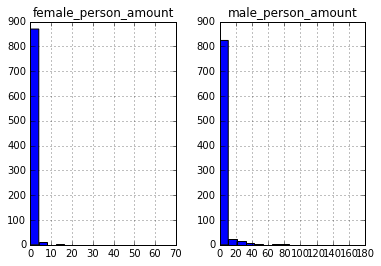

In [6]:
%pylab inline
g=df.hist(bins=15)

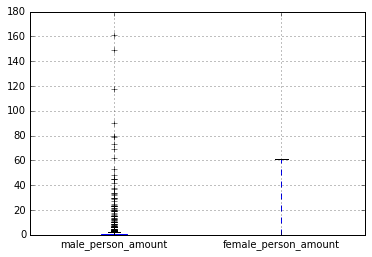

In [7]:
df.boxplot(return_type='axes')

# Remove data where there is no persons at all

In [8]:
#Remove data where there is no male person neither female  simultaneously
df_0=df[(df.male_person_amount==0)& (df.female_person_amount==0)]#628
df=df[(df.male_person_amount>0)| (df.female_person_amount>0)]#257
print "There are ",len(df),"profesions with at least one person"
df.describe()

There are  257 profesions with at least one person


,male_person_amount,female_person_amount
count,257.000000,257.000000
mean,10.447471,1.350195
std,20.531183,4.667241
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,10.000000,1.000000
max,161.000000,61.000000


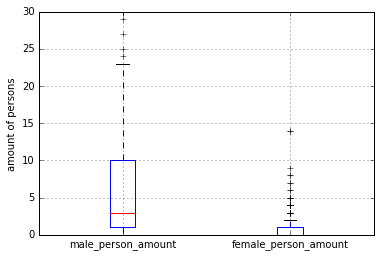

In [9]:
g=df.boxplot(return_type='axes')
plt.ylim(0,30)
#plt.xlabel("n=257")
plt.ylabel("amount of persons")
plt.show()

Mean of male person ratio:  0.86312298299


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


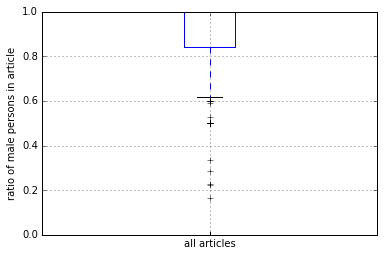

In [10]:
df["m_normalized"]=df.apply(lambda x: float(x["male_person_amount"])/float(x["male_person_amount"] + x["female_person_amount"]), axis = 1)
g=df.boxplot(column="m_normalized", return_type="axes")
plt.xticks([1],["all articles"])
plt.ylabel("ratio of male persons in article")
print "Mean of male person ratio: ",df.m_normalized.mean()

### Group by redirection bias

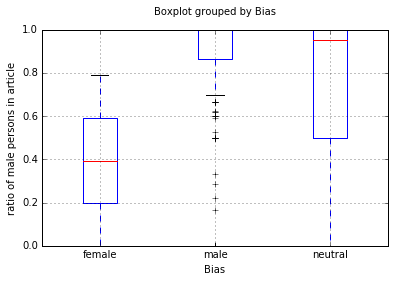

In [11]:
#data=pd.read_csv("de/wiki/all_wiki_pages.csv",sep='\t', encoding='utf-8',index_col=0) 
#df["Bias"]=df.apply(lambda x: data[data.WikiName.isin([x.name])].Bias.values[0], axis =1)
g=df.boxplot(by='Bias',column="m_normalized", return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()
#plt.xticks(range(1,4),["female\nn=2","male\nn=234","neutral\nn=21"])

In [12]:
#significance test
from scipy import stats  

m_val=df[df.Bias=="male"].m_normalized.values
f_val=df[df.Bias=="female"].m_normalized.values
n_val=df[df.Bias=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0583495821864 z_stat= 1.89306232089
MWW RankSum P for male and neutral distributions = 0.135760959059 z_stat= 1.49176424978
MWW RankSum P for female and neutral distributions = 0.190430263826 z_stat= -1.30930734142
MWW RankSum P for all together and male distributions = 0.671929209717 z_stat= -0.423501766874
MWW RankSum P for all together and female distributions = 0.0660133910361 z_stat= 1.83833272978
MWW RankSum P for all together and neutral distributions = 0.183637772329 z_stat= 1.32963739097


### Group by gender of profession label

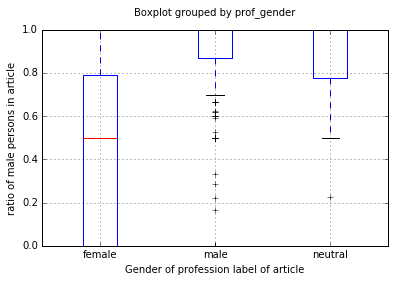

In [13]:
g=df.boxplot(column="m_normalized",by="prof_gender",return_type='axes')#n=9,n=239,n=9
plt.title("")
plt.ylabel("ratio of male persons in article")
plt.xlabel("Gender of profession label of article")
plt.show()

In [14]:
#significance test:

#significance test
from scipy import stats  

m_val=df[df.prof_gender=="male"].m_normalized.values
f_val=df[df.prof_gender=="female"].m_normalized.values
n_val=df[df.prof_gender=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.00374126834659 z_stat= 2.89919106346
MWW RankSum P for male and neutral distributions = 0.555656718844 z_stat= 0.589304959022
MWW RankSum P for female and neutral distributions = 0.0850890728162 z_stat= -1.72189206418
MWW RankSum P for all together and male distributions = 0.644026063252 z_stat= -0.462077055792
MWW RankSum P for all together and female distributions = 0.00533806767724 z_stat= 2.78589185896
MWW RankSum P for all together and neutral distributions = 0.643474786722 z_stat= 0.46284595758


### Group by Labor market

[]

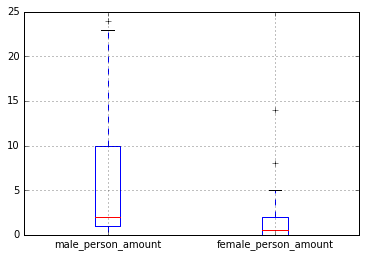

In [15]:
female_most_people=df[df.labor_market_domin=="female"]
male_most_people=df[df.labor_market_domin=="male"]

g=female_most_people.boxplot(return_type='axes',column=["male_person_amount","female_person_amount"])
g.set_ylim(0,25)
#g.set_xticks([1,2],["male persons","female persons"])
g.plot()

[]

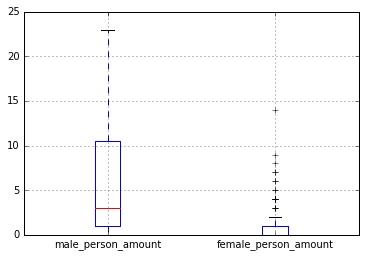

In [16]:
g=male_most_people.boxplot(return_type='axes',column=["male_person_amount","female_person_amount"])
g.set_ylim(0,25)
g.plot()

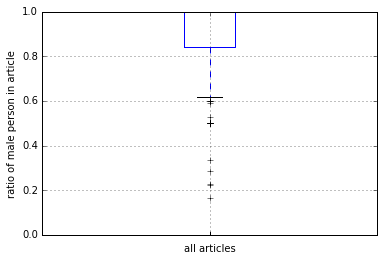

Ratio of male persons in all articles (mean): 0.862441132919


In [17]:
#only data where we have labour market statistics
df_all=df[~df.labor_market_domin.isnull()]

df_all.boxplot(column="m_normalized",return_type='axes')
plt.xlabel("all articles")
plt.xticks([1],"")
plt.ylabel("ratio of male person in article")
plt.show()
print "Ratio of male persons in all articles (mean):",df_all.m_normalized.mean()

Ratio of male persons in articles about female dominated profesion(mean): 0.822579992297
Ratio of male persons in articles about male dominated profesion(mean): 0.886006838696


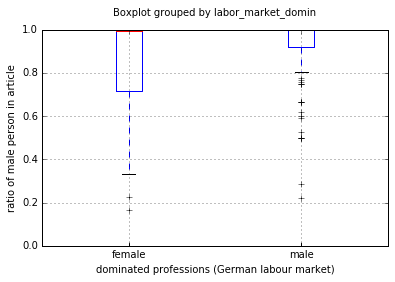

In [18]:
m_val=df_all[df_all.labor_market_domin=="male"].m_normalized.values
f_val=df_all[df_all.labor_market_domin=="female"].m_normalized.values
g_b_m=df_all.boxplot(column="m_normalized",return_type='axes',by="labor_market_domin")
plt.title("")#"ratio of men in artcles for professions where there are less than 50% female")
plt.xlabel("dominated professions (German labour market)")
plt.ylabel("ratio of male person in article")
print "Ratio of male persons in articles about female dominated profesion(mean):",df_all[df_all.labor_market_domin=="female"].m_normalized.mean()
print "Ratio of male persons in articles about male dominated profesion(mean):",df_all[df_all.labor_market_domin=="male"].m_normalized.mean()

C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


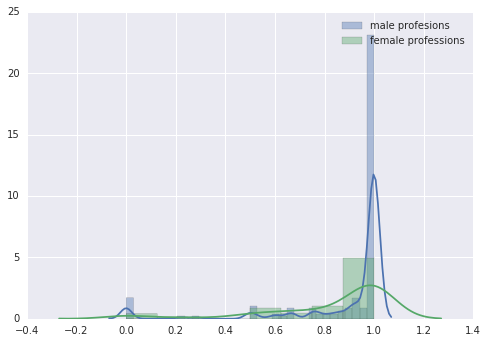

In [20]:
import seaborn as sns
g1=sns.distplot(m_val,label="male profesions")
g2=sns.distplot(f_val,label="female professions")
g2.legend()
#g.set_xlim(0,)

In [22]:
from scipy import stats  
  
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0170344426623 z_stat= 2.38596347777
MWW RankSum P for all together and male distributions = 0.254062743746 z_stat= -1.14053676772
MWW RankSum P for all together and female distributions = 0.1061039891 z_stat= 1.61595524864


## Distribution visualisation

(0, 200.0)

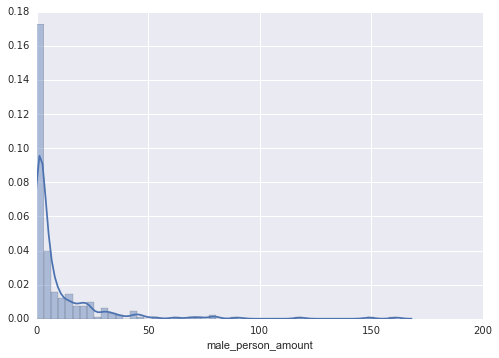

In [23]:
import seaborn as sns
#sns.set(color_codes=True)
g=sns.distplot(df.male_person_amount)
g.set_xlim(0,)

(0, 70.0)

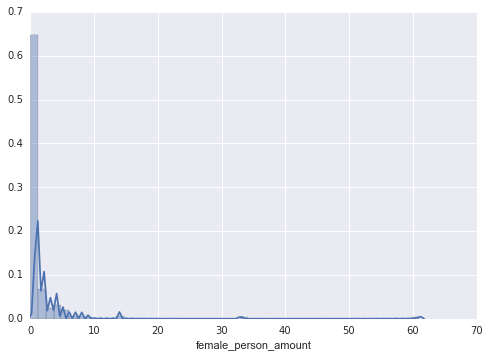

In [24]:
g=sns.distplot(df.female_person_amount)
g.set_xlim(0,)

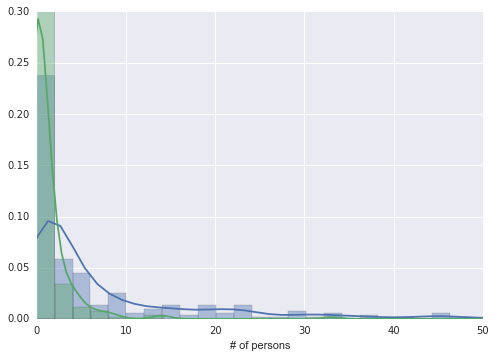

In [25]:
g1=sns.distplot(df.male_person_amount,bins=80)
g2=sns.distplot(df.female_person_amount,bins=30, kde_kws={"bw":1})
g1.set_xlim(0,50)
g1.set_ylim(0,0.3)
g1.set_xlabel("# of persons")

### Comulative distribution

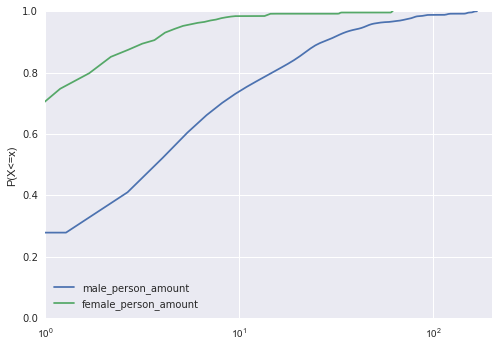

In [26]:
g=sns.kdeplot(df.male_person_amount,cumulative=True)#,linestyle="dotted")
g1=sns.kdeplot(df.female_person_amount,cumulative=True)
#g.set_ylim(1, 0)
g.set_xlim(1,)
g.set_xscale('log')
g.set_ylabel("P(X<=x)")

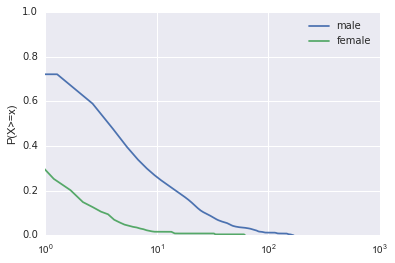

In [43]:
line = g.lines[0]
plt.plot(line.get_xdata(),1-line.get_ydata(), label="male")
line2=g.lines[1]
plt.plot(line2.get_xdata(),1-line2.get_ydata(), label="female")
plt.xscale("log")
plt.xlim(1,)
plt.legend()
plt.ylabel("P(X>=x)")

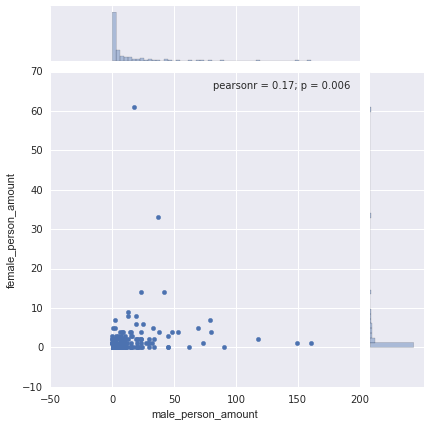

In [44]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount", data=df);

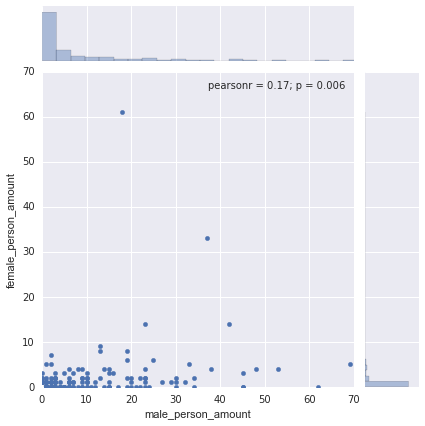

In [45]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, xlim=(0,70), ylim=(0,70))

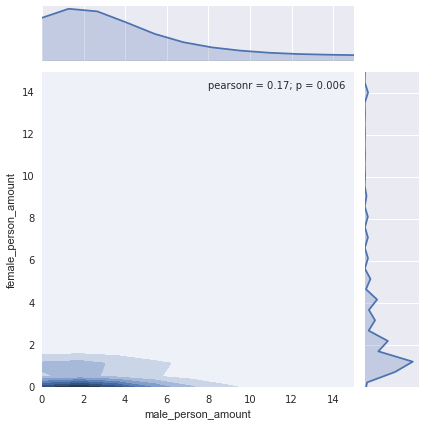

In [46]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, kind="kde",xlim=(0,15), ylim=(0,15))
#g.plot_joint(plt.scatter, c="black", s=30, linewidth=1, marker="+")

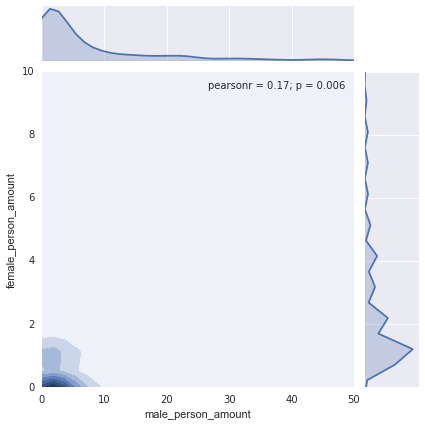

In [47]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, kind="kde",xlim=(0,50), ylim=(0,10))
#g.plot_joint(plt.scatter, c="black", s=30, linewidth=1, marker="+")

89


(0, 70.0)

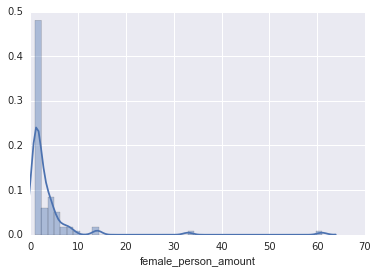

In [48]:
#del all where female zero
df3=df[(df.male_person_amount!=0) & (df.female_person_amount!=0)]#89
print len(df3)
g=sns.distplot(df3.female_person_amount)
g.set_xlim(0,)

# Polyglot

In [100]:
import polyglot
from polyglot.text import Text, Word
import json

def identify_name(raw_text):
    list_of_personal_names=[]
    text = Text(raw_text)
    text._BaseBlob__lang=polyglot.detect.base.Language.from_code("de") #we assign to the text German language!!
    try:
        if text.language.code!="de":
            print text.language.code
    except Exception, e:
        print 'failed in language detection'
        print str(e)
        return list_of_personal_names,True
    try:
        for t in text.entities:
            if (t.tag=="I-PER"):
                if (len(t[0])!=1)&(t[0].istitle()):
                    list_of_personal_names.append(t[0] if len(t)==1 else " ".join(i for i in t))# if i.isalpha()))   
        return list_of_personal_names,False
    except Exception, e:
        print 'failed in the entities'
        print str(e)
        return list_of_personal_names,True



In [104]:
#====progressbar   
#from progress.bar import Bar
#bar = Bar('Processing', max=20)
#bar.start()
#============


with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)
names={}
error_list=[]
for i in Dump:
    #bar.next()
    ne,error=identify_name(Dump[i]["text"].encode("utf-8").decode("utf-8").replace("\n",", "))
    if error:
        print "error at text of:",i
        error_list.append(i)
    else:
        name_list=list(set(ne))#delete duplicates
        name_list=filter(lambda k: i not in k, name_list)#clean from name of article
        name_list=[p for p in name_list if not((" e ." in p)|(" e." in p))]#clean from e.V.
        name_list=[p for p in name_list if not(p in ["Erw .","Hon .","Sta .","Ed .","Ma ?","Ass .","Kyu -","Éd .".decode("utf-8"),"Aja -"])] 
        
        #replace non aplchabetical values at the end of full name
        new_p=[]
        old_p=[]
        for p in name_list:
            if not(p[-1:].isalpha()):
                new_p_=p[:-2]
                if new_p_[-1:]==".":
                    new_p_=p[:-4]
                #print p, new_p
                new_p.append(new_p_)
                old_p.append(p)
        name_list=list(set(name_list)-set(old_p))
        name_list.extend(new_p)
        name_list=list(set(name_list)) 
        name_list=[p for p in name_list if not(("Ed"==p)|("Verl"== p))]#clean Ed and Verl
        name_list=[p for p in name_list if not(("Mr"==p)|("Co"==p)|("Ch"==p)|("Chr"==p)|("Sc"==p)|("St"==p))]#clean Mr Co Ch Chr Sc St
        names[i]=name_list
#bar.finish()

failed in the entities
'ascii' codec can't encode character u'\xd6' in position 0: ordinal not in range(128)
error at text of: Flugbegleiter


In [105]:
#get from error data# scip not readable char
#error_list[0]#"Flugbegleiter"
ne,error=identify_name(Dump["Flugbegleiter"]["text"][:14036].replace("\n",", ")+" "+Dump["Flugbegleiter"]["text"][14050:].replace("\n",", "))
if error:
    print "error at text of:",i
    error_list.append(i)
else:
    ne=list(set(ne))
    ne=filter(lambda k: "Flugbegleiter" not in k, ne)#clean from name of article
    ne=[p.replace(" .","") for p in ne]#clean from " ."
    print ne
    names["Flugbegleiter"]=ne

[u'Maria Weckesser', u'Saftschubse', u'Strahlenexposition', u'Passagiersitzplatz', u'Nelly Diener', u'Heather Poole', u'Guinness', u'Flugg\xe4sten', u'Kathrin Leineweber', u'Ellen Church', u'Ingo Matuschek', u'Annette Lies', u'Ron Akana', u'Andrea Brandl', u'Annette', u'Gray', u'Piper']


In [106]:
print len(names)#,len(Dump)
with open('de/wiki/all_name_entity_person_polyglot.json', 'w') as out:
    json.dump(names, out, indent=4, sort_keys=True,encoding="utf-8")

885


# filter first names and lastnames when repeats

In [146]:
#if first name of full name
#if last name of full name
#if full name ends or beginsw ith this name
###in more detail:
###first two names, check that there are two names and check at the begining and end of full name
###Ex: Matthäus Merian => Matthäus Merian der Ältere

#if second/third name in full name

#add Marcel Marceau, del all with Marceau


import json


with open('de/wiki/all_name_entity_person_polyglot.json', 'r') as in_f:
    names=json.load(in_f,encoding="utf-8")


from collections import defaultdict
to_del=defaultdict(list)
to_add=defaultdict(list)
for prof in names:
    #print prof
    for p in names[prof]:
        for p2 in names[prof]:
            if (p not in to_del[prof]):#|(p2 not in to_del[prof]):
                if p!=p2:
                    if p in p2:
                        if p+"s"==p2:
                            to_del[prof].append(p2) 
                            #print p,"=>",p2
                        elif p+"’s".decode("utf-8")==p2:
                            to_del[prof].append(p2)
                            #print p,"=>",p2  
                        elif (p2.split(" ")[0]==p):
                            to_del[prof].append(p) #exclude p from list
                            #print p,"=>",p2
                        elif (p2.split(" ")[-1]==p):
                            to_del[prof].append(p)
                            #print p,"=>",p2
                        elif (len(p.split(" "))==2)&(p2[:len(p)]==p):
                            #print p,"=>",p2
                            #print prof
                            to_del[prof].append(p)
                        elif (p2[-len(p):]==p):
                            #print p,"=>",p2
                            to_del[prof].append(p)
                        elif (p2[-len(p)-1:]==p+"s"):
                            #print p,"=>",p2
                            to_del[prof].append(p2)
                            to_del[prof].append(p)
                            to_add[prof].append(p2[:-1])
                        elif ("Marceau" in p)& ("Marcel Marceau" in p2):
                            to_del[prof].append(p2)
                            to_del[prof].append(p)
                            to_add[prof].append("Marcel Marceau")
                        elif (p in p2.split(" "))&(len(p2.split(" "))>1):
                            #print p,"=>",p2
                            to_del[prof].append(p)
                        #else:
                            #print p,"=>",p2
    to_del[prof]=list(set(to_del[prof]))
    to_add[prof]=list(set(to_add[prof]))
#del
for prof in to_del:
    if len(to_del[prof])>0:
        #print to_del[prof]
        names[prof]=[n for n in names[prof] if n not in to_del[prof]]
        names[prof]=list(set(names[prof]))


print"===Add"
#add
for prof in to_add:
    if len(to_add[prof])>0:
        #print to_add[prof]
        names[prof].extend(to_add[prof])
        names[prof]=list(set(names[prof]))

===Add


In [147]:
import re
from collections import defaultdict

#parse 

def del_and_add_to_dict(names,names_add,names_del):
    print "We add:",len(names_add),"new instances and del ",len(names_del)#1,9
    for prof in names_del:
        if len(names_del[prof])>0:
            names[prof]=[n for n in names[prof] if n not in names_del[prof]]
            names[prof]=list(set(names[prof]))
    for prof in names_add:
        if len(names_add[prof])>0:
            names[prof].extend(names_add[prof])
            names[prof]=list(set(names[prof])) 
    return names



names_add=defaultdict(list)
names_del=defaultdict(list)
for prof in names:
    for p in names[prof]:
        if "Verl" in p:
            if " . Laaber Verlag" in p:
                new_p=p.replace(" . Laaber Verlag","")
                if new_p not in names[prof]:
                    names_add[prof].append(new_p)
            names_del[prof].append(p)
        elif " . " in p:
            new_p=p.replace(" . ", ". ")
            names_del[prof].append(p)
            if new_p not in names[prof]:
                names_add[prof].append(new_p)
        elif (". " in p):
            pass
        elif ("." in p) | ("&" in p) |("/" in p) | (")" in p):
            names_del[prof].append(p)
            print p
        elif "–".decode("utf-8") in p:#its not a minus  it is deffise
            new_p=p.split("–".decode("utf-8"))[0].strip()
            if (new_p not in names[prof]) & (new_p!="Attrice"):
                names_add[prof].append(new_p)
            names_del[prof].append(p)
        elif (p=="Sta")|(p=="Erw")|(p=="Ed")|(p=="Ma")|(p=="Ass")|(("Law"in p)&("urist"in prof))\
        |((p=="Jun")&(prof=="Arzt"))|((p=="Kyu")&(prof=="Polizeivollzugsbeamter"))|((p=="May")&(prof=="Butler"))\
        |((p=="Arx")&(prof=="Diakon"))|((p=="Wes")&(prof=="Unternehmensberater"))|(p=="Éd".decode("utf-8"))\
        |((p=="Aja")&(prof=="Richter"))|((p=="Due")&(prof=="Wirtschaftsprüfer".decode("utf-8")))\
        |((p=="Hon")&(prof=="Professor")):#Law/Laws in Juist
            names_del[prof].append(p)
            #print p,",",new_p,",",prof
            
print len(names_add),len(names_del)#79,113
names=del_and_add_to_dict(names,names_add,names_del) 

names_add=defaultdict(list)
names_del=defaultdict(list)
for prof in names:
    for p in names[prof]:
        if "verlag" in p:
            if ". Henschelverlag" in p:
                new_p=p.replace(". Henschelverlag","").strip()
                if new_p not in names[prof]:
                    names_add[prof].append(new_p)
            names_del[prof].append(p)
            
names=del_and_add_to_dict(names,names_add,names_del) 

Emmerich )
0 1
===Add


In [148]:
print len(names)#,len(Dump)
with open('de/wiki/all_name_entity_person_polyglot.json', 'w') as out:
    json.dump(names, out, indent=4, sort_keys=True,encoding="utf-8")

885


# Find names from Name_entity_person

In [427]:
import pandas as pd
import math

names_2=pd.read_csv("gender_names_40000.txt",sep=" ",header=None,index_col=False,names=range(1,84),encoding="utf-8")
names_2=names_2[names_2.columns[:6]]
def move_value(x):
    if x[1] in ["1M","1F","?M","?F"]:
        return x[2]
    else:
        return x[3]
names_2["first_name"]=names_2.apply(lambda x:  move_value(x),axis=1) #all M F in third column
names_3=names_2[~names_2[1].isin(["?","?F","?M","="])]
names_3 = names_3[[1,'first_name']]
names_4 = names_3[[1,'first_name']]
names_4["first_name"]=names_4.apply(lambda x: x.first_name.replace("<r^>",u'\u0159').replace(u'\u2030',u'\xe4').replace("<l/>",u'\u0142').title().replace("è".decode("utf-8"),"é".decode("utf-8")).\
                                    replace(u'\xec',u'\xed'),axis=1)
#Examples wher names_4 is usefull:
#u'Napoléon',u'Karolína',u'Bedřich',u'Czesław',u'Bartholomäus',u'Mathäus',u'Kätchen',u'Bolesław',u'Stanisław'

In [428]:
import pandas as pd
import numpy as np
import json


with open('de/wiki/all_name_entity_person_polyglot.json', 'r') as in_f:
    names=json.load(in_f,encoding="utf-8")

df_names_gender=pd.read_csv("name_gender_genderiz.txt", sep=" ",header=None,
                            names=["name","gender","conf","n"],index_col=False,encoding="utf-8")
df_names_gender.gender=df_names_gender.gender.str.replace("\[\(u'","").str.replace("\',","") 
df_names_gender.conf=df_names_gender.conf.str.replace("u'","").str.replace("\',","").convert_objects(convert_numeric=True)

df_names_gender_None=df_names_gender[df_names_gender.gender.str.contains("None")]
df_names_gender=df_names_gender[df_names_gender.gender.str.contains("male")]

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [357]:
'''import textwrap
from difflib import ndiff
import chardet

with open("gender_names_40000.txt")as myfile:#"name_gender_genderiz.txt") as myfile:
    for i in range(1,300):
        input_bytes = myfile.readline()[:20]
        result = chardet.detect(input_bytes)
        try:
            expected_unicode = input_bytes.decode("utf-8")
        except LookupError:
            expected_unicode = ''
        try:
            detected_unicode = input_bytes.decode(result['encoding'])
        except (LookupError, UnicodeDecodeError):
            detected_unicode = ''
        if result['encoding'].lower() != "utf-8":
            wrapped_expected = '\n'.join(textwrap.wrap(expected_unicode, 100)) + '\n'
            wrapped_detected = '\n'.join(textwrap.wrap(detected_unicode, 100)) + '\n'
            diff = ''.join(ndiff(wrapped_expected.splitlines(True),
                             wrapped_detected.splitlines(True)))
        else:
            diff = ''
        print result,diff'''

{'confidence': 1.0, 'encoding': 'ascii'}   M  Aad

{'confidence': 1.0, 'encoding': 'ascii'}   M  Aadam

{'confidence': 1.0, 'encoding': 'ascii'}   F  Aadje



UnicodeEncodeError: 'ascii' codec can't encode character u'\u2248' in position 5: ordinal not in range(128)

In [433]:
#We have such examples:
#"K\u00f6nig Alexander I","Deutschland Egon Erwin Kisch"
#We look into all words in a name and store first occurency in DB


from collections import defaultdict

names_gender=defaultdict(dict)
all_other=[]
all_other_1=[]
all_other_2=[]
all_other_none=[]
for prof in names:
    for p in names[prof]:
        if (p.split(" ",1)[0] in df_names_gender.name.values):
            gender=df_names_gender[df_names_gender.name==p.split(" ",1)[0]].gender.values[0]
            if gender not in names_gender[prof]:
                names_gender[prof][gender]=[]
            names_gender[prof][gender].append(p)   
        elif p.split(" ",1)[0] in names_3.first_name.values: 
            g=names_3[names_3.first_name==p.split(" ",1)[0]][1].values[0]
            if (g=="F")|(g=="1F"):
                gender="female"
            else:
                gender="male"
            if gender not in names_gender[prof]:
                names_gender[prof][gender]=[] 
            names_gender[prof][gender].append(p)
        elif p.split()[0] in names_4.first_name.values: 
            g=names_4[names_4.first_name==p.split(" ",1)[0]][1].values[0]
            if (g=="F")|(g=="1F"):
                gender="female"
            else:
                gender="male"
            if gender not in names_gender[prof]:
                names_gender[prof][gender]=[] 
            names_gender[prof][gender].append(p)
        elif ((p.split(" ",1)[0][-1:]=="s") & (p.split(" ",1)[0][:-1] in df_names_gender.name.values)&\
             (p not in ["Criss Angel","Mimes","Tages","Christians","Dantes","Hors","Reuters"])):
            gender=df_names_gender[df_names_gender.name==p.split(" ",1)[0][:-1]].gender.values[0]
            if len(p.split())==1:
                real_name=p.split(" ",1)[0][:-1]
            else:
                first_name,last_name=p.split(" ",1)
                real_name=first_name[:-1]+" "+last_name
            #print "=",p,",",real_name,",",prof
            #check weather real_name in the list of names
            if [i for i in names[prof] if ((p.split()[0][:-1] in i)&(i!=p)) ]:
                pass
            else:
                if gender not in names_gender[prof]:
                    names_gender[prof][gender]=[]
                names_gender[prof][gender].append(real_name)
        elif (len(p.split())<3)&((p.split()[0] in df_names_gender_None.name.values)):
            all_other_none.append(p+" , "+prof)
            pass
        elif (len(p.split(" "))>1):
            if (len(p.split())==2) & (not ( (p.split()[1].istitle())&(len(p.split()[1])>1))):
                all_other.append(p+" , "+prof)
                #print p
            #if the second word starts from capital letter and more than one char
            else:
                found=""
                for i in p.split()[1:]:
                    if (i.istitle())& (len(i)>1):
                        if i in df_names_gender.name.values:
                            #print "!!found! in df_names_gender:",p
                            gender=df_names_gender[df_names_gender.name==i].gender.values[0]
                            if gender not in names_gender[prof]:
                                names_gender[prof][gender]=[]
                            names_gender[prof][gender].append(p)
                            found=p
                            break
                        elif i in names_3.first_name.values:
                            #print "!!found! in names_3:",p
                            g=names_3[names_3.first_name==i][1].values[0]
                            if (g=="F")|(g=="1F"):
                                gender="female"
                            else:
                                gender="male"
                            if gender not in names_gender[prof]:
                                names_gender[prof][gender]=[] 
                            names_gender[prof][gender].append(p)
                            found=p
                            break
                if len(found)==0:
                    all_other_2.append(p+" , "+prof)
                    #print p+" , "+prof
                        
        else:
            all_other_1.append(p+" , "+prof)
#print all_other,all_other_1,all_other_2,all_other_none

In [442]:
#store everything filtered from algorithm
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('de/all_not_person_polyglot.pckl', 'w') as f:
    pickle.dump([all_other,all_other_1,all_other_2,all_other_none], f)

# Getting back the objects:
with open('de/all_not_person_polyglot.pckl') as f:
    all_other,all_other_1,all_other_2,all_other_none = pickle.load(f)

In [443]:
#add counts
for prof in names_gender:
    if names_gender[prof].has_key("male"):
        names_gender[prof]["male_amount"]=len(names_gender[prof]["male"])
    if names_gender[prof].has_key("female"):
        names_gender[prof]["female_amount"]=len(names_gender[prof]["female"])
        
        
with open('de/all_person_polyglot_new.json', 'w') as out:
    json.dump(names_gender, out, indent=4, sort_keys=True)

# Analysis of polyglot names

In [523]:
import json
import pandas as pd
with open('de/all_person_polyglot_new.json', 'r') as in_f:
    names_gender=json.load(in_f)
#we have 394 articles
df=pd.DataFrame.from_dict(names_gender,orient="index")
#print "# of pages with name_entities: ",len(df)
df = df[(~df.male.isnull()) | (~df.female.isnull())] 
print "# of pages where at least one peron mentioned: ",len(df)
df.male_amount.fillna(0, inplace=True)
df.female_amount.fillna(0, inplace=True)
df

# of pages where at least one peron mentioned:  394


,male,female_amount,female,male_amount
Abfallbeauftragter,"[Schmidt, Stephan, Erich]",0,NaN,3
Abt,"[Leo XIII, Papst Leo X, Schmitt, Karl Martell,...",1,[Martina Wiech],5
Altenpflegehelfer,"[Thomas Klie, Robert, Bernd Hein]",1,[Virginia Guerra],3
Altenpfleger,"[Manfred Engl, Frank Drieschner]",3,"[Brigitte Zellhuber, Annette Riedel, Sonja Sch...",2
Angestellter,"[Ulf Kadritzke, Fritz Croner, Ruprecht, Charle...",3,"[Lang, Irmgard, Tatjana Timoschenko]",14
Anwendungsprogrammierer,[Springer Gabler],0,NaN,1
Anästhesietechnischer Assistent,"[Martin Bauer, Florian Eckert]",1,[Robin Rüsenberg],2
Apotheker,"[Franz - Josef Kuhlen, Christoph Friedrich, Jo...",1,[Magdalena Meub],26
Arbeitsvermittler,"[Jonas F. Puck, Holger Schütze, Anders, Oliver...",1,[Henriette Heber],5
Architekt,"[Hanno Wolfensberger, Michael O’Shea, Günther ...",7,"[Tanja Kullack, Kristina Lowis, Ulrike Eichhor...",11


In [445]:
df.describe()

,female_amount,male_amount
count,394.000000,394.000000
mean,1.964467,9.005076
std,5.130734,16.350486
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,3.000000
75%,2.000000,10.000000
max,70.000000,175.000000


C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001DF839E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015E7A9B0>]], dtype=object)

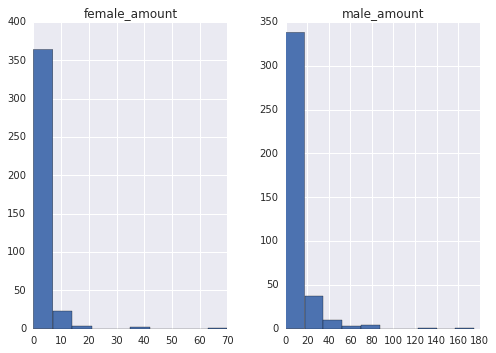

In [447]:
#%pylab inline
import seaborn as sns
df.hist()

(0, 25)

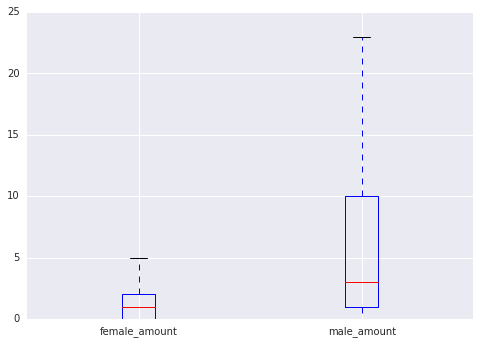

In [448]:
#for all data
g=df.boxplot(return_type='axes')
g.set_ylim(0,25)

In [449]:
#merger about_pages and df 885 and 393
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
df=pd.concat([about_pages,df],join='inner',axis=1)
print len(df)
df

394


,male_person_amount,all_link,lead,text,male_person,female_person,female_person_amount,Bias,prof_gender,labor_market_domin,profession,male,female_amount,female,male_amount
Abfallbeauftragter,0,"[Unternehmer, Kreislaufwirtschaft, Abfallbesei...",Ein Abfallbeauftragter oder Betriebsbeauftragt...,Ein Abfallbeauftragter oder Betriebsbeauftragt...,[],[],0,male,male,male,Abfallbeauftragter,"[Schmidt, Stephan, Erich]",0,NaN,3
Abt,4,"[Kirchliche_Heraldik, Galero, Chorkleidung, Ha...","Ein Abt (von spätlat. abbas, aus aram. abba „V...","Ein Abt (von spätlat. abbas, aus aram. abba „V...","[Karl_Martell, Leo_X., Franz_I._(Frankreich), ...",[],0,male,male,female,Abt,"[Leo XIII, Papst Leo X, Schmitt, Karl Martell,...",1,[Martina Wiech],5
Altenpflegehelfer,0,"[Hessen, Nordrhein-Westfalen, Baden-Württember...",Altenpflegehilfe mit der Berufsbezeichnung Alt...,Altenpflegehilfe mit der Berufsbezeichnung Alt...,[],[],0,male,male,female,Altenpflegehelfer,"[Thomas Klie, Robert, Bernd Hein]",1,[Virginia Guerra],3
Altenpfleger,0,"[Ambulante_Pflege, Häusliche_Krankenpflege, So...",Altenpfleger und Altenpflegerinnen pflegen und...,Altenpfleger und Altenpflegerinnen pflegen und...,[],[],0,male,male,female,Altenpfleger,"[Manfred Engl, Frank Drieschner]",3,"[Brigitte Zellhuber, Annette Riedel, Sonja Sch...",2
Angestellter,7,"[Arbeitnehmer, Arbeiter, Arbeitsrecht, Sozialr...","Ein Angestellter, auch Privatangestellter, ist...","Ein Angestellter, auch Privatangestellter, ist...","[Fritz_Croner, Michel_Crozier, Arnd_Zschiesche...",[Irmgard_Keun],1,male,male,NaN,Angestellter,"[Ulf Kadritzke, Fritz Croner, Ruprecht, Charle...",3,"[Lang, Irmgard, Tatjana Timoschenko]",14
Anwendungsprogrammierer,0,"[Programmierer, Anwendungsprogramm, Customizin...","Anwendungsprogrammierer sind Programmierer, di...","Anwendungsprogrammierer sind Programmierer, di...",[],[],0,male,male,male,Anwendungsprogrammierer,[Springer Gabler],0,NaN,1
Anästhesietechnischer Assistent,0,"[Ausbildungsberuf, Gesundheits-_und_Krankenpfl...",Die Berufsgruppe Anästhesietechnische(r) Assis...,Die Berufsgruppe Anästhesietechnische(r) Assis...,[],[],0,male,male,female,Anästhesietechnischer Assistent,"[Martin Bauer, Florian Eckert]",1,[Robin Rüsenberg],2
Apotheker,20,"[Léo_Apotheker, Arzneimittel, Bundes-Apotheker...",Apotheker sind Fachkräfte für Arzneimittel. Si...,Apotheker sind Fachkräfte für Arzneimittel. Si...,"[Léo_Apotheker, Friedrich_II._(HRR), Friedrich...",[Magdalena_Meub],1,neutral,male,female,Apotheker,"[Franz - Josef Kuhlen, Christoph Friedrich, Jo...",1,[Magdalena Meub],26
Arbeitsvermittler,0,"[Bundesagentur_für_Arbeit, Jobcenter, Öffentli...",Die Tätigkeit eines Arbeitsvermittlers ist auf...,Die Tätigkeit eines Arbeitsvermittlers ist auf...,[],"[Henriette_Heber, Christine_Rädlinger]",2,male,male,female,Arbeitsvermittler,"[Jonas F. Puck, Holger Schütze, Anders, Oliver...",1,[Henriette Heber],5
Architekt,2,"[Erz-, Gebäude, Bauwerk, Hochbau, Architektur,...","Der Architekt (griech. ἀρχιτέκτων architékton,...","Der Architekt (griech. ἀρχιτέκτων architékton,...","[Eugène_Viollet-le-Duc, Vitruv]",[],0,male,male,male,Architekt,"[Hanno Wolfensberger, Michael O’Shea, Günther ...",7,"[Tanja Kullack, Kristina Lowis, Ulrike Eichhor...",11


# Female dominated professions

147


(0, 25)

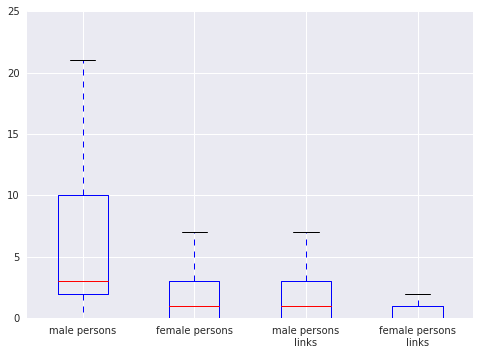

In [458]:
female_most_people=df[df.labor_market_domin=="female"]#147
print len(female_most_people)
g=female_most_people.boxplot(column=["male_amount","female_amount",
                                     "male_person_amount","female_person_amount"],return_type='axes')
plt.xticks(range(1,5),["male persons","female persons","male persons\nlinks","female persons\nlinks"])
plt.ylim(0,25)

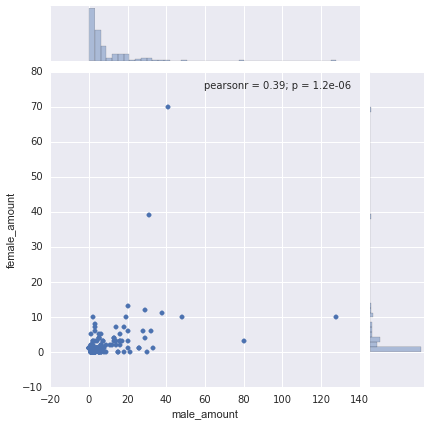

In [459]:
import seaborn as sns
g=sns.jointplot(x="male_amount", y="female_amount", data=female_most_people)

# Male dominated professions

In [460]:
male_most_people=df[df.labor_market_domin=="male"]#240
male_most_people

,male_person_amount,all_link,lead,text,male_person,female_person,female_person_amount,Bias,prof_gender,labor_market_domin,profession,male,female_amount,female,male_amount
Abfallbeauftragter,0,"[Unternehmer, Kreislaufwirtschaft, Abfallbesei...",Ein Abfallbeauftragter oder Betriebsbeauftragt...,Ein Abfallbeauftragter oder Betriebsbeauftragt...,[],[],0,male,male,male,Abfallbeauftragter,"[Schmidt, Stephan, Erich]",0,NaN,3
Anwendungsprogrammierer,0,"[Programmierer, Anwendungsprogramm, Customizin...","Anwendungsprogrammierer sind Programmierer, di...","Anwendungsprogrammierer sind Programmierer, di...",[],[],0,male,male,male,Anwendungsprogrammierer,[Springer Gabler],0,NaN,1
Architekt,2,"[Erz-, Gebäude, Bauwerk, Hochbau, Architektur,...","Der Architekt (griech. ἀρχιτέκτων architékton,...","Der Architekt (griech. ἀρχιτέκτων architékton,...","[Eugène_Viollet-le-Duc, Vitruv]",[],0,male,male,male,Architekt,"[Hanno Wolfensberger, Michael O’Shea, Günther ...",7,"[Tanja Kullack, Kristina Lowis, Ulrike Eichhor...",11
Arrangeur,80,"[Arrangement, Komponist, Komposition_(Musik), ...",Ein musikalischer Arrangeur ist der Einrichter...,Ein musikalischer Arrangeur ist der Einrichter...,"[Leonard_Bernstein, Irwin_Kostal, George_Gersh...","[Carla_Bley, Melba_Liston, Maria_Schneider_(Ko...",4,male,male,male,Arrangeur,"[Bill Holman, Billy May, Michael Gibson, Claus...",10,"[Dani Felber, Gigi, Mary Lou Williams, Maria S...",82
Artist (Darsteller),2,"[Artistik, Kontorsionistin, Darstellende_Kunst...",Ein Artist (von mittellateinisch artista u. fr...,Ein Artist (von mittellateinisch artista u. fr...,"[Enrico_Rastelli, Omar_Kingsley]","[Lily_Braun, Caroline_Loyo, Therese_Renz, Jenn...",7,male,male,male,Artist (Darsteller),"[Hermann Haupt, Roman, Omar Kingsley, Lothar G...",16,"[Mathilde Monnet, Claire Heliot, Therese Renz,...",5
Astronom,3,"[Jan_Vermeer, Galileo_Galilei, Stern, Gestirn,...",Ein Astronom (griechisch ἄστρον ástron ‚Stern‘...,Ein Astronom (griechisch ἄστρον ástron ‚Stern‘...,"[Jan_Vermeer, Galileo_Galilei, Wilhelm_Olbers]",[],0,male,male,male,Astronom,[Wilhelm Olbers],0,NaN,1
Audiodesign,0,"[Digitalisierung, Geräuschemacher, Tontechnike...",Audiodesign nennt sich die Gestaltung von Tona...,Audiodesign nennt sich die Gestaltung von Tona...,[],[],0,neutral,neutral,male,Audiodesign,[Hannes Raffaseder],0,NaN,1
Ausbilder,0,"[Berufsbildungsgesetz_(Deutschland), Unternehm...",Nach dem Berufsbildungsgesetz (BBiG) wird als ...,Nach dem Berufsbildungsgesetz (BBiG) wird als ...,[],[],0,male,male,male,Ausbilder,[Jacobs],0,NaN,1
Automatenfachmann,1,"[Berufsbildungsgesetz_(Deutschland), Ausbildun...",Der Automatenfachmann ist in Deutschland ein s...,Der Automatenfachmann ist in Deutschland ein s...,[Philipp_Rösler],[],0,male,male,male,Automatenfachmann,[Philipp Rösler],0,NaN,1
Ballettrepetitor,3,"[Korrepetitor, Ballett, Tanzensemble, Klavier,...",Als Ballettrepetitor [auch: Ballettkorrepetito...,Als Ballettrepetitor [auch: Ballettkorrepetito...,"[Arnold_Jacobshagen, Siegfried_Mauser, Daniel_...",[],0,male,male,male,Ballettrepetitor,"[Siegfried Mauser, Arnold Jacobshagen, Ulrich ...",0,NaN,6


(0, 30)

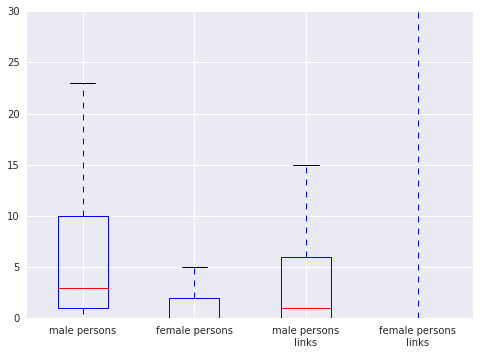

In [463]:
g=male_most_people.boxplot(column=["male_amount","female_amount",
                                     "male_person_amount","female_person_amount"],return_type='axes')
plt.xticks(range(1,5),["male persons","female persons","male persons\nlinks","female persons\nlinks"])
plt.ylim(0,30)

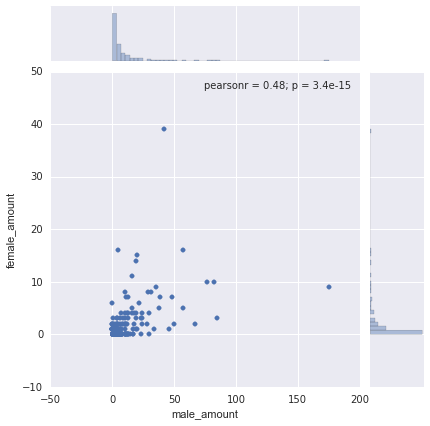

In [464]:
import seaborn as sns
g=sns.jointplot(x="male_amount", y="female_amount", data=male_most_people)

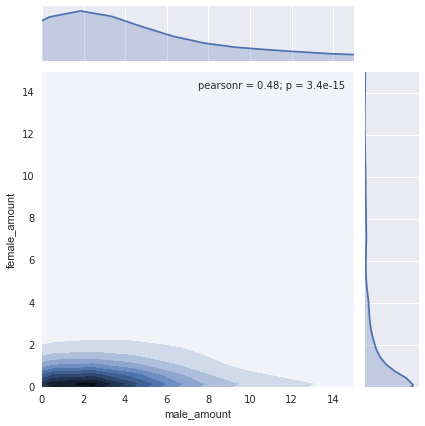

In [465]:
g=sns.jointplot(x="male_amount", y="female_amount",data=male_most_people, kind="kde",xlim=(0,15), ylim=(0,15))

# Compare two datasets

### labor market

Ratio of male persons in all articles (mean): 0.821566125135


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


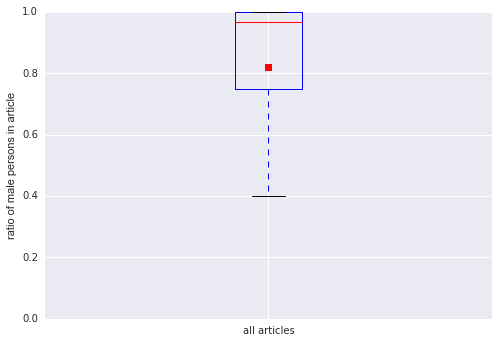

In [467]:
df_all=df[~df.labor_market_domin.isnull()]
df_all["m_normalized"]=df_all.apply(lambda x: float(x["male_amount"])/float(x["male_amount"] + x["female_amount"]), axis = 1)
df_all.boxplot(column="m_normalized",showmeans=True,return_type='axes')
plt.xticks([1],["all articles"])
plt.ylabel("ratio of male persons in article")
print "Ratio of male persons in all articles (mean):",df_all.m_normalized.mean()

Ratio of male persons in articles about female dominated profesion(mean): 0.769325827996
Ratio of male persons in articles about male dominated profesion(mean): 0.853563307133


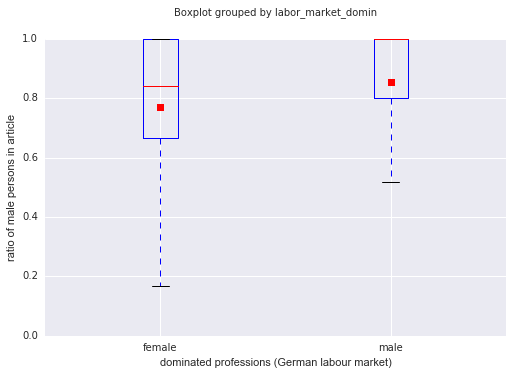

In [468]:
f_val=df_all[df_all.labor_market_domin=="female"].m_normalized.values
print "Ratio of male persons in articles about female dominated profesion(mean):",df_all[df_all.labor_market_domin=="female"].m_normalized.mean()
m_val=df_all[df_all.labor_market_domin=="male"].m_normalized.values
print "Ratio of male persons in articles about male dominated profesion(mean):",df_all[df_all.labor_market_domin=="male"].m_normalized.mean()

df_all.boxplot(column="m_normalized",return_type='axes',by="labor_market_domin",showmeans=True )
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.xlabel("dominated professions (German labour market)")
plt.show()

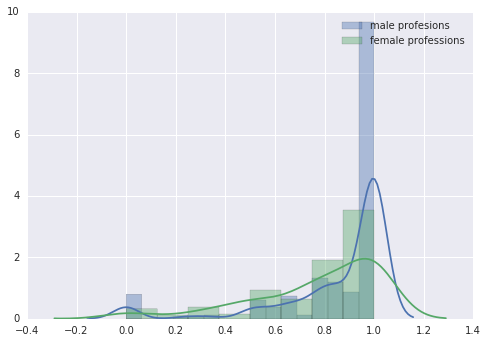

In [469]:
g1=sns.distplot(m_val,label="male profesions")
g2=sns.distplot(f_val,label="female professions")
g2.legend()
#g.set_xlim(0,)

In [470]:
from scipy import stats  
  
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and female distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and male distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 9.48531840171e-05 z_stat= 3.90339379238
MWW RankSum P for all together and female distributions = 0.0586301195459 z_stat= -1.89095673759
MWW RankSum P for all together and male distributions = 0.00885064524769 z_stat= 2.61776994533


| | p-val | z |
| :-|:-:|:-:|
| male professions & female professions |    9.488-05     |   3.90    | 
| all_together & female profession |     0.058    |     -1.89    | 
| all_together & male profession |     0.008    |     2.61    | 

### Bias

2 355 37


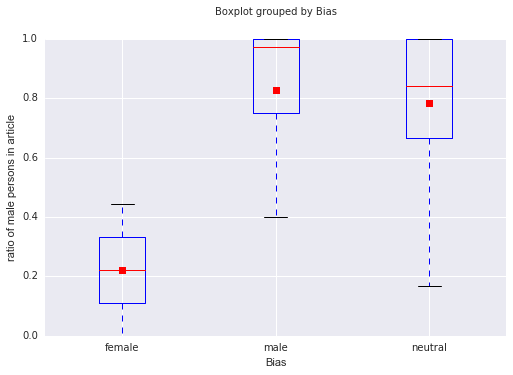

In [471]:
#df["Bias"]=df.apply(lambda x: data[data.WikiName.isin([x.name])].Bias.values[0], axis =1)
df["m_normalized"]=df.apply(lambda x: float(x["male_amount"])/float(x["male_amount"] + x["female_amount"]), axis = 1)
print len(df[df.Bias=="female"]),len(df[df.Bias=="male"]),len(df[df.Bias=="neutral"])
g=df.boxplot(by='Bias',column="m_normalized",showmeans=True, return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()

In [472]:
#significance test
from scipy import stats  

m_val=df[df.Bias=="male"].m_normalized.values
f_val=df[df.Bias=="female"].m_normalized.values
n_val=df[df.Bias=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0283904164506 z_stat= 2.19184893339
MWW RankSum P for male and neutral distributions = 0.272304440348 z_stat= 1.09777113129
MWW RankSum P for female and neutral distributions = 0.0385158566153 z_stat= -2.06932225489
MWW RankSum P for all together and male distributions = 0.725281306003 z_stat= -0.351409300476
MWW RankSum P for all together and female distributions = 0.0294808811556 z_stat= 2.17699579539
MWW RankSum P for all together and neutral distributions = 0.342613647396 z_stat= 0.949013693897


### gender of profession label

10 360 24


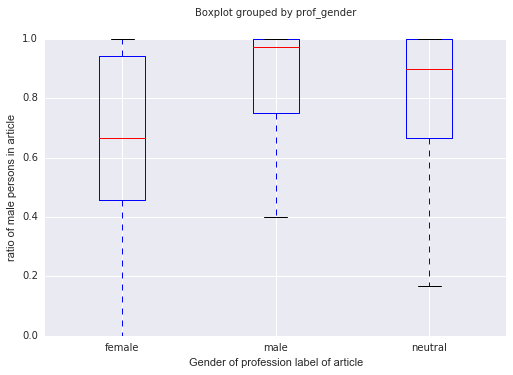

In [473]:
print len(df[df.prof_gender=="female"]),len(df[df.prof_gender=="male"]),len(df[df.prof_gender=="neutral"])

g=df.boxplot(column="m_normalized",by="prof_gender",return_type='axes')#n=9,n=239,n=9
plt.title("")
plt.ylabel("ratio of male persons in article")
plt.xlabel("Gender of profession label of article")
plt.show()#n=10,n=359 ,n=24

In [474]:
#significance test:

#significance test
from scipy import stats  

m_val=df[df.prof_gender=="male"].m_normalized.values
f_val=df[df.prof_gender=="female"].m_normalized.values
n_val=df[df.prof_gender=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0454139428877 z_stat= 2.00080004214
MWW RankSum P for male and neutral distributions = 0.43837988935 z_stat= 0.774931919926
MWW RankSum P for female and neutral distributions = 0.212293836192 z_stat= -1.24728276093
MWW RankSum P for all together and male distributions = 0.718831202013 z_stat= -0.360021304039
MWW RankSum P for all together and female distributions = 0.0547340634208 z_stat= 1.92098131296
MWW RankSum P for all together and neutral distributions = 0.514000543852 z_stat= 0.652621154961


# Examples for polyglot usage

In [78]:
#======EXAMPLE
import json
import polyglot
from polyglot.text import Text, Word

#Example1
text = Text(u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Olga Zagovora war nett.")
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print("{:<16}{}".format("Word", "POS Tag")+"\n"+"-"*30)
for word, tag in text.pos_tags:
    print(u"{:<16}{:>2}".format(word, tag))
    
#Example 2   
with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)
    
raw_text=Dump["Abfallbeauftragter"]["text"]
raw_text_1st_sentence=raw_text.split(".",1)[0].encode("utf-8").decode("utf-8")
print raw_text_1st_sentence
text = Text(raw_text_1st_sentence)
#?text.pos_tags   
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print text.language,type(text.language)
print polyglot.detect.base.Language(["Deutsch", "de", 99.0, 1205])
print polyglot.detect.base.Language.from_code("de")
#set the language
text._BaseBlob__lang=polyglot.detect.base.Language.from_code("de")#Text("Abfallbeauftragter").language
print text.language,type(text.language)
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print("{:<16}{}".format("Word", "POS Tag")+"\n"+"-"*30)
for word, tag in text.pos_tags:
    print(u"{:<16}{:>2}".format(word, tag))
#print(text.entities)
all_names=text.entities
list_of_personal_names=[]
for t in text.entities:
    if t.tag=="I-PER":
        list_of_personal_names.append(t[0] if len(t)==1 else " ".join(i for i in t))
print list_of_personal_names


Language Detected: Code=de, Name=Deutsch

Word            POS Tag
------------------------------
In              PROPN
Großbritannien  PROPN
war             PROPN
Gandhi          PROPN
und             PROPN
Arnim           PROPN
mit             PROPN
dem             PROPN
westlichen      ADJ
Lebensstil      NOUN
vertraut        ADJ
geworden        ADJ
.               PROPN
Olga            PROPN
Zagovora        PROPN
war             PROPN
nett            ADJ
.               PROPN
Ein Abfallbeauftragter oder Betriebsbeauftragter für Abfall berät den Unternehmer oder Betreiber einer Anlage und die Betriebsangehörigen in Angelegenheiten, die für die Kreislaufwirtschaft und die Abfallbeseitigung bedeutsam sein können
Language Detected: Code=de, Name=Deutsch

name: Deutsch     code: de       confidence:  99.0 read bytes:  1205 <class 'polyglot.detect.base.Language'>
name: Deutsch     code: de       confidence:  99.0 read bytes:  1205
name: Deutsch     code: de       confidence: 100.0 read by

In [2]:
#=====Download this before polyglot usage=====
from polyglot.downloader import downloader
downloader.supported_tasks(lang="de")
downloader.download("embeddings2.de")
downloader.download("pos2.de")
downloader.download("ner2.de")
#=========================

[polyglot_data] Downloading package ner2.de to C:\Anaconda\Lib\site-
[polyglot_data]     packages\polyglot\data...


True

# Stanford approach==> Does not work

In [6]:
import nltk
from nltk.tag.stanford import NERTagger
nltk.internals.config_java("C:\\Java\\jdk1.8.0_25\\bin\\java.exe")#jre1.8.0_66
path_to_model ="C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz"
path_to_jar = "C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\stanford-ner-3.6.0.jar"
st = NERTagger(path_to_model,path_to_jar)#, 'stanford-ner/stanford-ner.jar')
#st = NERTagger("C:\Users\Lelka\Downloads\stanford-german-2015-10-14-models.jar",
#               "C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\stanford-ner.jar")
#download from http://nlp.stanford.edu/software/CRF-NER.html

#st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

#from nltk.tag import StanfordPOSTagger
#st = StanfordPOSTagger('english-bidirectional-distsim.tagger') 
text = """YOUR TEXT GOES HERE"""

for sent in nltk.sent_tokenize(text):
    tokens = nltk.tokenize.word_tokenize(sent)
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1]=='PERSON': print tag

[Found C:\Java\jdk1.8.0_25\bin\java.exe: C:\Java\jdk1.8.0_25\bin\java.exe]
CRFClassifier invoked on Thu Mar 03 01:54:17 CET 2016 with arguments:
   -loadClassifier C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz -textFile c:\users\lelka\appdata\local\temp\tmptwpxy4 -outputFormat slashTags
loadClassifier=C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz
textFile=c:\users\lelka\appdata\local\temp\tmptwpxy4
outputFormat=slashTags
Exception in thread "main" java.lang.NoClassDefFoundError: org/slf4j/LoggerFactory
	at edu.stanford.nlp.io.IOUtils.<clinit>(IOUtils.java:42)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifier(AbstractSequenceClassifier.java:1484)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifierNoExceptions(AbstractSequenceClassifier.java:1497)
	at edu.stanford.nlp.ie.crf.CRFClassifier.main(CRFClassifier

OSError: Java command failed!

In [6]:
from nltk.parse.stanford import StanfordParser
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordNeuralDependencyParser
from nltk.tag.stanford import StanfordPOSTagger, StanfordNERTagger
from nltk.tokenize.stanford import StanfordTokenizer

In [79]:
from nltk.tag.stanford import StanfordPOSTagger
st = StanfordPOSTagger('english-bidirectional-distsim.tagger')

LookupError: 

===========================================================================
  NLTK was unable to find stanford-postagger.jar! Set the CLASSPATH
  environment variable.

  For more information, on stanford-postagger.jar, see:
    <http://nlp.stanford.edu/software>
===========================================================================

In [2]:
import nltk
from nltk.tag import StanfordNERTagger
#nltk.internals.config_java("C:\\Java\\jdk1.8.0_73\\bin\\java.exe")
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       path_to_jar="c:\stanford\stanford-ner-2015-12-09\stanford-ner-3.6.0.jar") 
st.tag('Rami Eid is studying at Stony Brook University in NY'.split())

CRFClassifier invoked on Thu Mar 03 14:40:03 CET 2016 with arguments:
   -loadClassifier C:\Stanford\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz -textFile c:\users\zagovooa\appdata\local\temp\tmpmepzqe -outputFormat slashTags -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions "tokenizeNLs=false" -encoding utf8
tokenizerFactory=edu.stanford.nlp.process.WhitespaceTokenizer
tokenizerOptions="tokenizeNLs=false"
loadClassifier=C:\Stanford\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz
encoding=utf8
textFile=c:\users\zagovooa\appdata\local\temp\tmpmepzqe
outputFormat=slashTags
Exception in thread "main" java.lang.NoClassDefFoundError: org/slf4j/LoggerFactory
	at edu.stanford.nlp.io.IOUtils.<clinit>(IOUtils.java:42)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifier(AbstractSequenceClassifier.java:1484)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifierNoExceptions(AbstractSequ

OSError: Java command failed : ['C:\\Java\\jdk1.8.0_73\\bin\\java.exe', '-mx1000m', '-cp', 'c:\\stanford\\stanford-ner-2015-12-09\\stanford-ner-3.6.0.jar', 'edu.stanford.nlp.ie.crf.CRFClassifier', '-loadClassifier', 'C:\\Stanford\\stanford-ner-2015-12-09\\classifiers\\english.all.3class.distsim.crf.ser.gz', '-textFile', 'c:\\users\\zagovooa\\appdata\\local\\temp\\tmpmepzqe', '-outputFormat', 'slashTags', '-tokenizerFactory', 'edu.stanford.nlp.process.WhitespaceTokenizer', '-tokenizerOptions', '"tokenizeNLs=false"', '-encoding', 'utf8']

# NLTK Approach (too slow)

In [1]:
import nltk
#nltk.download()
print(nltk.__version__)

3.1


In [21]:
import nltk
from nltk.tree import Tree
import re

def identify_person_in_text(text):
    person_list = []
    for sentence in nltk.sent_tokenize(text):
        #print sentence
        sent1 = nltk.word_tokenize(sentence)
        sent2 = nltk.pos_tag(sent1)
        sent3 =  nltk.ne_chunk(sent2,binary = False)#, binary=True)
        #print sent3
        #sent3.draw()
        person_list.append(re.findall(r'PERSON\s(.*?)/',str(sent3)))
    return person_list
def identify_person_in_text2(text):
    person_list = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))).subtrees(filter=lambda t: t.label() == 'PERSON'):
            person_list.append(' '.join(c[0] for c in chunk.leaves()))
    return person_list

def identify_person_in_text3(text):
    person_list = []
    for sentence in nltk.sent_tokenize(text):
        #print sentence
        sent1 = nltk.word_tokenize(sentence)
        sent2 = nltk.pos_tag(sent1)
        sent3 =  nltk.ne_chunk(sent2,binary = False)#, binary=True)
        person = []
        name = ""
        for subtree in sent3.subtrees(filter=lambda t: t.label() == 'PERSON'):
            for leaf in subtree.leaves():
                person.append(leaf[0])
                #print person
            if len(person) > 1: #avoid grabbing lone surnames
                for part in person:
                    name += part + ' '
                if name[:-1] not in person_list:
                    person_list.append(name[:-1])
                name = ''
            else:
                person_list.append(person[0])
            person = []
    return person_list


#######==========Example 1

import progressbar
from itertools import groupby
import json

bar = progressbar.ProgressBar(maxval=5, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

text=u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Ralf Lämmel war nett. Olga Zagovora kommt auch."
person_nltk={}

with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)
text=Dump["Abfallbeauftragter"]["text"]
j=0
bar.start()
if True:#for article in Dump:
    bar.update(j+1)
    if j<=3:
        #text=Dump[article]["text"]
        person_nltk[article]=identify_person_in_text2(text)
    #else:
        #break
        
    j+=1
bar.finish()

In [23]:
#============ Example 2
import timeit
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

text1="I love you. Irma loves Ralf."
text2=u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Alfred Lämmel war nett. Olga Zagovora kommt auch."

wrapped1=wrapper(identify_person_in_text,text1)
print timeit.timeit(wrapped1, number=3)
wrapped2=wrapper(identify_person_in_text2,text1)
print timeit.timeit(wrapped2, number=3)
wrapped3=wrapper(identify_person_in_text3,text1)
print timeit.timeit(wrapped3, number=3)
#wrapped4=wrapper(identify_person_in_text3,text2)
#print timeit.timeit(wrapped4,number=3)

61.6410712819
65.3662776135
65.4470353946
96.695457625
